<a href="https://colab.research.google.com/github/nikshitakarkera/Flower-Detection-Model/blob/main/FlowerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import os
import random
import warnings
import cv2
warnings.filterwarnings('ignore')

from keras import backend as K
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical

# specifically for cnn
from keras.layers import Activation
from keras.layers import MaxPooling2D, BatchNormalization

In [ ]:
# Set image_size and batch_size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Target Directory
directory = "/content/drive/MyDrive/flowers"

# Train Data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
             directory,
             subset='training',
             validation_split=0.2,
             image_size=IMAGE_SIZE,
             batch_size=BATCH_SIZE,
             seed=42)

# Valid data
valid_data = tf.keras.preprocessing.image_dataset_from_directory(
            directory,
            subset='validation',
            validation_split=0.2,
            image_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
             seed=42)

Found 4337 files belonging to 5 classes.
Using 3470 files for training.
Found 4337 files belonging to 5 classes.
Using 867 files for validation.


In [ ]:
labels = ['dandelion', 'daisy','tulip','sunflower','rose']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


In [ ]:
data = get_data("/content/drive/MyDrive/flowers")

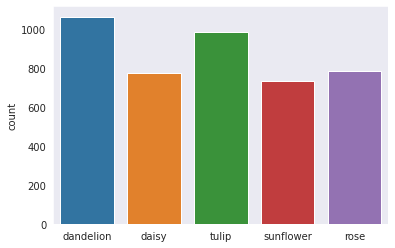

In [ ]:
l = []
for i in data:
    l.append(labels[i[1]])
sns.set_style('dark')
sns.countplot(l)
plt.show()

In [ ]:
class_names = train_data.class_names
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
label_encode = LabelEncoder()
class_names_label_encode = label_encode.fit_transform(class_names)
class_names_label_encode

array([0, 1, 2, 3, 4])

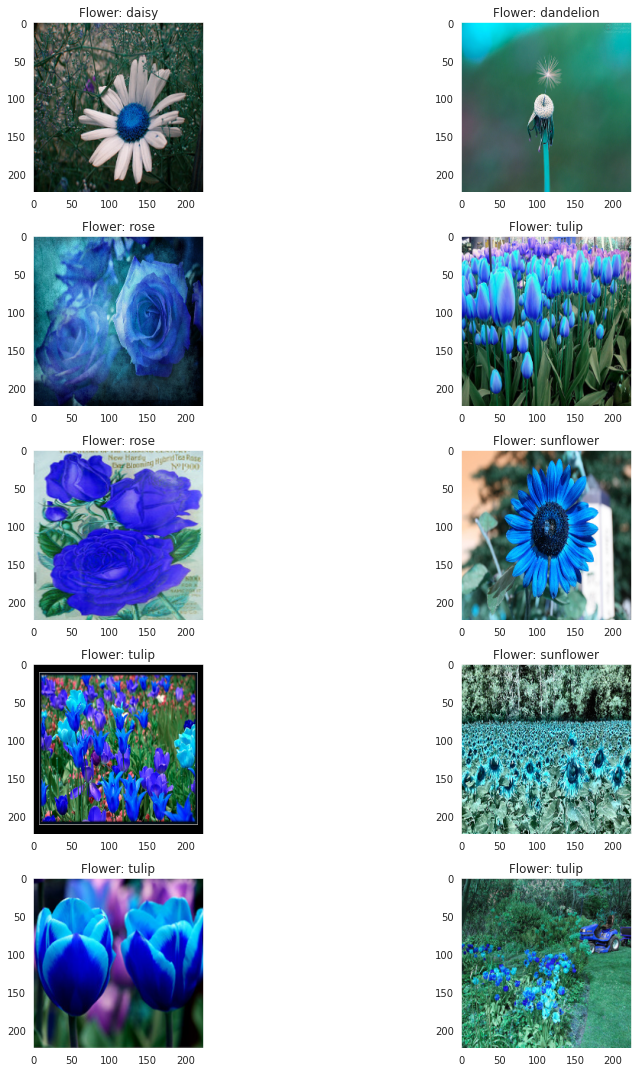

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Flower: '+labels[data[l][1]])
        
plt.tight_layout()

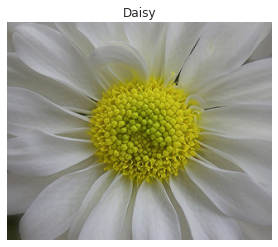

In [ ]:
img = plt.imread("/content/drive/MyDrive/flowers/daisy/100080576_f52e8ee070_n.jpg")
plt.imshow(img)
plt.title("Daisy")
plt.axis("off")
plt.show();

In [ ]:
def preprocess_image(image, label, image_shape=224):
    
    img = tf.image.resize(image, [image_shape, image_shape])
    img = img/225.
    
    return tf.cast(img, tf.float32), label

In [ ]:
preprocess_image(image=img, label='tulip')

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.6024702 , 0.6024702 , 0.5935813 ],
         [0.624375  , 0.624375  , 0.620703  ],
         [0.6444026 , 0.6444026 , 0.6444026 ],
         ...,
         [0.684472  , 0.684472  , 0.6755832 ],
         [0.68476194, 0.68476194, 0.68476194],
         [0.66539603, 0.66539603, 0.66539603]],
 
        [[0.597252  , 0.597252  , 0.5883631 ],
         [0.6199029 , 0.6199029 , 0.611014  ],
         [0.6406349 , 0.6406349 , 0.6406349 ],
         ...,
         [0.683684  , 0.683684  , 0.67479515],
         [0.6843474 , 0.6843474 , 0.6843474 ],
         [0.6633233 , 0.6633233 , 0.6633233 ]],
 
        [[0.59244823, 0.59244823, 0.5835594 ],
         [0.6174865 , 0.6174865 , 0.60859764],
         [0.63870037, 0.63870037, 0.6351077 ],
         ...,
         [0.6787002 , 0.6787002 , 0.6698113 ],
         [0.6793056 , 0.6793056 , 0.6793056 ],
         [0.6520704 , 0.6520704 , 0.6520704 ]],
 
        ...,
 
        [[0.19752772, 0.21086106

In [ ]:
# map the preprocess_image to train_data
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# shuffle the data
train_data = train_data.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)


# map the preprocess_image to valid_data
valid_data = valid_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# shuffle the data
valid_data = valid_data.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, valid_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [ ]:
# Set random seed
tf.random.set_seed(42)

# model 1
model_1 = Sequential([
    Conv2D(filters=32, kernel_size=4, padding='same', activation='relu',input_shape=(224,224,3)),
    MaxPool2D(2,2),
    Conv2D(filters=64, kernel_size=4, padding='same', activation='relu'),
    MaxPool2D(2,2), 
    Conv2D(filters=64, kernel_size=4, padding='same', activation='relu'),
    MaxPool2D(2,2),
    Dropout(0.5),
    Flatten(),
    Dense(len(class_names_label_encode), activation='softmax')
])

# Compile
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer='adam',
               metrics=['accuracy'])

# Fit
history_1 = model_1.fit(train_data,
                       epochs=5,
                       validation_data=valid_data)

Epoch 1/5
109/109 [==============================] - 588s 5s/step - loss: 1.3426 - accuracy: 0.4205 - val_loss: 1.0783 - val_accuracy: 0.5582
Epoch 2/5
109/109 [==============================] - 549s 5s/step - loss: 1.0735 - accuracy: 0.5867 - val_loss: 1.0924 - val_accuracy: 0.5236
Epoch 3/5
109/109 [==============================] - 559s 5s/step - loss: 0.9466 - accuracy: 0.6297 - val_loss: 0.9401 - val_accuracy: 0.6321
Epoch 4/5
109/109 [==============================] - 549s 5s/step - loss: 0.8239 - accuracy: 0.6902 - val_loss: 0.9015 - val_accuracy: 0.6494
Epoch 5/5
109/109 [==============================] - 546s 5s/step - loss: 0.7051 - accuracy: 0.7421 - val_loss: 0.9507 - val_accuracy: 0.6355


In [ ]:
# model_1 summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        65600     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [ ]:
dire='/content/drive/MyDrive/flowers'

In [ ]:
categories=['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']
features=[]
for i in categories:
    path=os.path.join(dire,i)
    num_classes=categories.index(i)
    for img in os.listdir(path):
        if img.endswith('.jpg'):
            
            img_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
            img_array=cv2.resize(img_array,(150,150))
            features.append([img_array,num_classes])

In [ ]:
X=[]
y=[]
for i,j in features:
    X.append(i)
    y.append(j)

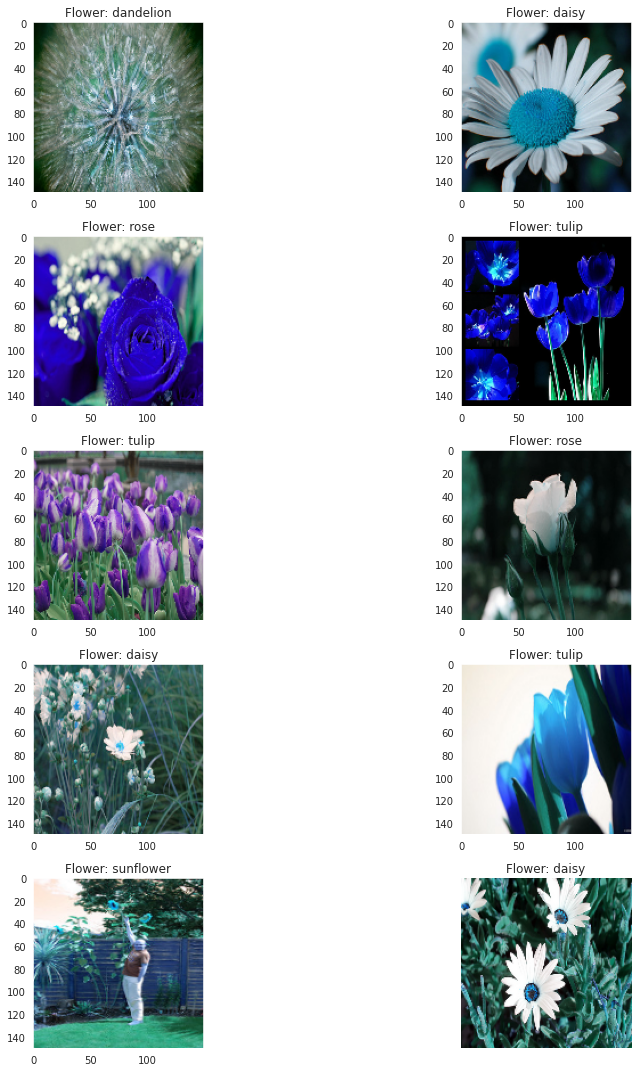

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=np.random.randint(0,len(y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+categories[y[l]])
plt.axis('off')        
plt.tight_layout()

In [ ]:
X=np.array(X).reshape(-1,150,150,3)/255.0

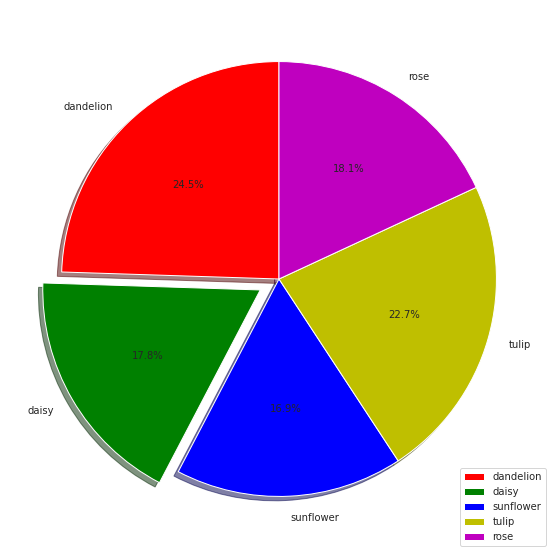

In [ ]:
list_dandelion=len([i for i in y if i==0])
list_daisy=len([i for i in y if i==1])
list_sunflower=len([i for i in y if i==2])
list_tulip=len([ i for i in y if i==3])
list_rose=len([i for i in y if i==4])

list_species=[list_dandelion,list_daisy,list_sunflower,list_tulip,list_rose]

sns.set_style('whitegrid')
plt.figure(figsize=(18,10))
plt.pie(list_species,labels=categories,startangle=90,colors=['r','g','b','y','m'],autopct='%1.1f%%',explode = (0, 0.1, 0, 0,0),shadow=True)
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.utils import to_categorical
y=to_categorical(y)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=12)

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2, padding="same"))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2, padding="same"))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2, padding="same"))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(5, activation="softmax"))

In [ ]:
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)


datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)


model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 72, 72, 64)        0         
                                                      

In [ ]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=128),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 128)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

NameError: ignored

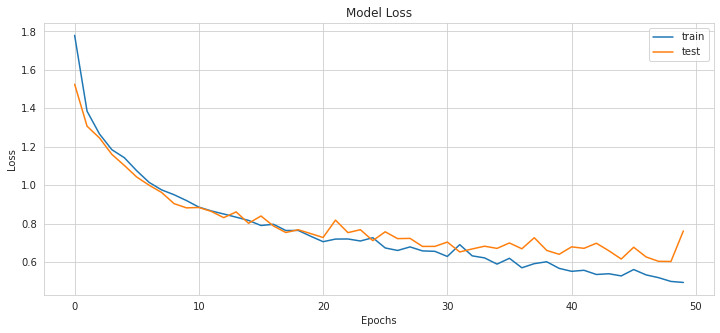

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

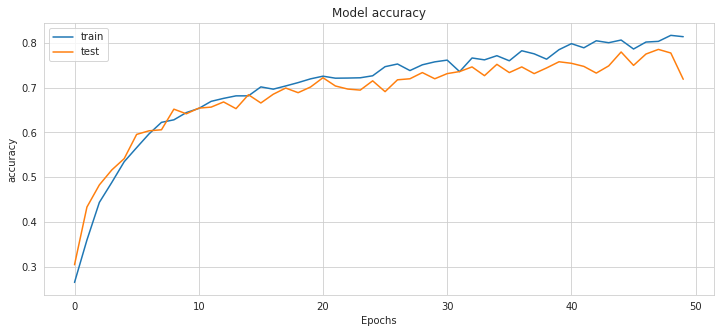

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
preds=model.predict(x_test)

predictions=np.argmax(preds,axis=1)

correct_class=[]
incorrect_class=[]
i=0
for i in range(len(y_test)):
    if(np.argmax(y_test[i])==predictions[i]):
        correct_class.append(i)
    if(len(correct_class)==8):
        break

28/28 [==============================] - 12s 411ms/step


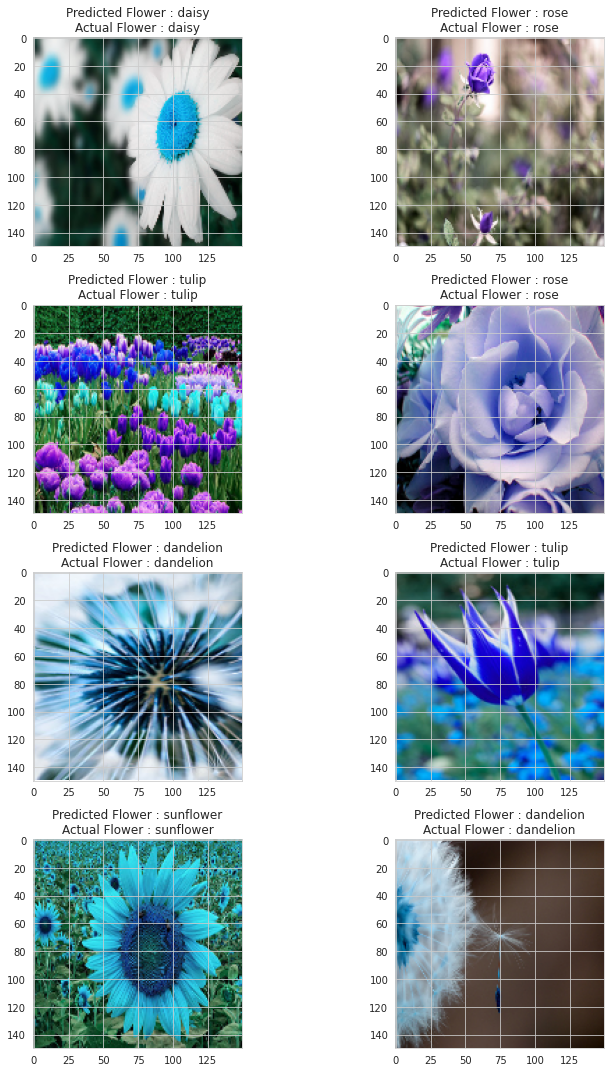

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[correct_class[count]])
        ax[i,j].set_title("Predicted Flower : "+ categories[predictions[correct_class[count]]] +"\n"+"Actual Flower : "+ categories[np.argmax(y_test[correct_class[count]])])
        plt.tight_layout()
        count+=1

In [ ]:
import requests
from PIL import Image
from io import BytesIO

def process_image(url):
    response=requests.get(url)
    img=Image.open(BytesIO(response.content))
    fix,ax=plt.subplots(1,3,figsize=(15,20))
    ax[0].imshow(img)
    ax[0].set_title('image')
    
    #grayscale and normalization
    img=np.array(img)
    img=cv2.cvtColor(img,cv2.IMREAD_COLOR)
    print(img.shape)
    img=img/255.0
    ax[1].imshow(img)
    ax[1].set_title('color image')
    
    #resizing
    img=cv2.resize(img,(150,150))
    print(img.shape)
    ax[2].imshow(img)
    ax[2].set_title('predicted image')
    plt.tight_layout()
    img=np.expand_dims(img,axis=0)
    #making it model ready
    
    print(img.shape)
    return img
def predict(url):
    img=process_image(url)
    label=model.predict(img)
    final_1=np.argmax(label,axis=1)[0]
    plt.xlabel(categories[final_1])
    return categories[final_1]
    

In [ ]:
predict("https://cdn.britannica.com/36/82536-050-7E968918/Shasta-daisies.jpg?w=400&h=300&c=crop") 

NameError: ignored